# Reinforcement Learning for Optimal Delivery Route

## 1. Import Agents, Environment and Necessary Libraries

In [5]:
import numpy as np

from dqn import DQNAgent
from environment import DeliveryEnvironment
from q_learning import QLearningAgent
from sarsa import SarsaAgent
from visualize import plot_comparison

## The Training Loop

In [6]:
def train(agent, env, episodes=1000, total_reward=None):
    """
    Trains a reinforcement learning agent in the given environment.
    """
    if isinstance(agent, DQNAgent):
        print("Training DQN Agent...")
        for episode in range(episodes):
            state = env.reset()
            done = False
            total_reward = 0
            while not done:
                action = agent.get_action(state)
                if action is None:
                    break
                next_state, reward, done = env.step(action)
                agent.remember(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
            agent.replay()
            if (episode + 1) % 50 == 0:
                print(
                    f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")

    elif isinstance(agent, QLearningAgent):
        print("Training Q-Learning Agent...")
        for episode in range(episodes):
            state = env.reset()
            done = False
            total_reward = 0
            while not done:
                action = agent.get_action(state)
                if action is None:
                    break
                next_state, reward, done = env.step(action)
                agent.update(state, action, reward, next_state)
                state = next_state
                total_reward += reward
            if (episode + 1) % 50 == 0:
                print(
                    f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")

    elif isinstance(agent, SarsaAgent):
        print("Training SARSA Agent...")
        for episode in range(episodes):
            state = env.reset()
            done = False
            total_reward = 0
            action = agent.get_action(state)
            while not done:
                if action is None:
                    break
                next_state, reward, done = env.step(action)
                next_action = agent.get_action(next_state)
                agent.update(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
                total_reward += reward
            if (episode + 1) % 50 == 0:
                print(
                    f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")
    else:
        raise TypeError("Unsupported agent type")


## Evaluation Function

In [7]:
def evaluate(agent, env, episodes=100):
    """
    Evaluates a trained agent's performance.
    """
    total_rewards = []
    total_times = []
    total_distances = []

    original_epsilon = getattr(agent, 'epsilon', 0)
    if hasattr(agent, 'epsilon'):
        agent.epsilon = 0

    for _ in range(episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        episode_time = 0
        episode_distance = 0

        while not done:
            action = agent.get_action(state)
            if action is None:
                break

            start_pos = env.current_pos
            next_state, reward, done = env.step(action)
            end_pos = env.current_pos

            episode_reward += reward
            episode_time += 1
            episode_distance += np.linalg.norm(start_pos - end_pos)
            state = next_state

        total_rewards.append(episode_reward)
        total_times.append(episode_time)
        total_distances.append(episode_distance)

    if hasattr(agent, 'epsilon'):
        agent.epsilon = original_epsilon

    return {
        "avg_reward": np.mean(total_rewards),
        "avg_time": np.mean(total_times),
        "avg_distance": np.mean(total_distances)
    }

Configure Environment and Agents

Training Q-Learning Agent...
Episode 50/2000, Total Reward: -41.07, Epsilon: 0.10
Episode 100/2000, Total Reward: -37.43, Epsilon: 0.10
Episode 150/2000, Total Reward: -42.74, Epsilon: 0.10
Episode 200/2000, Total Reward: -47.12, Epsilon: 0.10
Episode 250/2000, Total Reward: -49.08, Epsilon: 0.10
Episode 300/2000, Total Reward: -43.41, Epsilon: 0.10
Episode 350/2000, Total Reward: -41.20, Epsilon: 0.10
Episode 400/2000, Total Reward: -35.84, Epsilon: 0.10
Episode 450/2000, Total Reward: -36.45, Epsilon: 0.10
Episode 500/2000, Total Reward: -41.92, Epsilon: 0.10
Episode 550/2000, Total Reward: -48.65, Epsilon: 0.10
Episode 600/2000, Total Reward: -36.94, Epsilon: 0.10
Episode 650/2000, Total Reward: -51.53, Epsilon: 0.10
Episode 700/2000, Total Reward: -52.36, Epsilon: 0.10
Episode 750/2000, Total Reward: -47.53, Epsilon: 0.10
Episode 800/2000, Total Reward: -45.36, Epsilon: 0.10
Episode 850/2000, Total Reward: -41.72, Epsilon: 0.10
Episode 900/2000, Total Reward: -40.24, Epsilon: 0.10


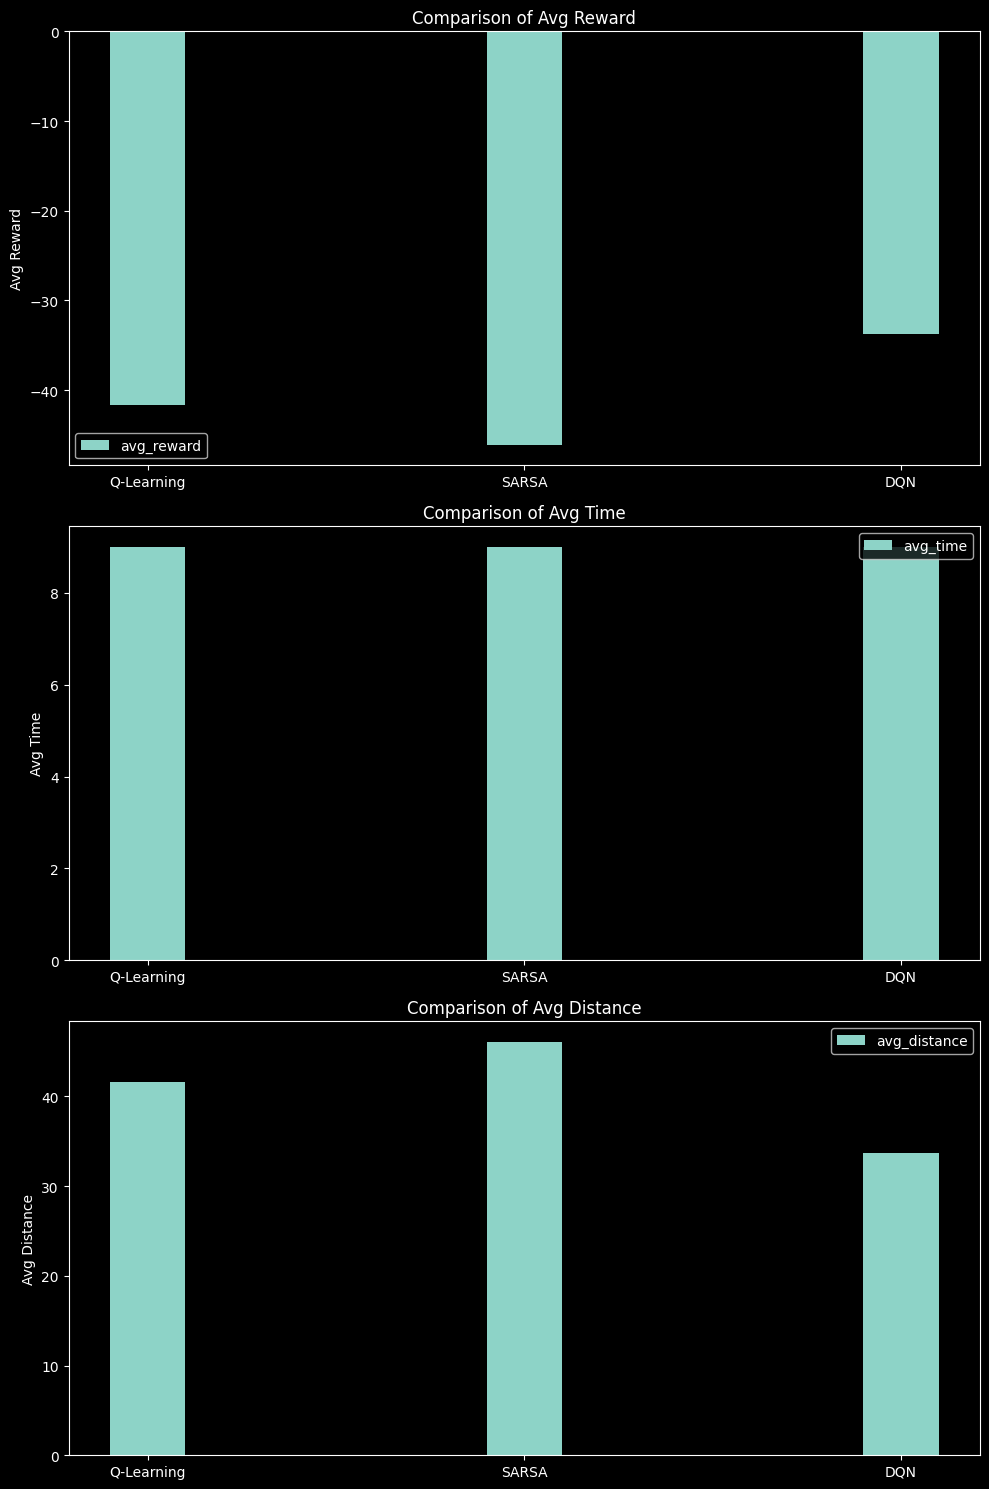

In [8]:
env = DeliveryEnvironment(num_locations=10, grid_size=10)

# --- Q-Learning ---
q_agent = QLearningAgent(env, alpha=0.1, gamma=0.9, epsilon=0.1)
train(q_agent, env, episodes=2000)
q_results = evaluate(q_agent, env)
print("Q-Learning training complete.")

# --- SARSA ---
sarsa_agent = SarsaAgent(env, alpha=0.1, gamma=0.9, epsilon=0.1)
train(sarsa_agent, env, episodes=2000)
sarsa_results = evaluate(sarsa_agent, env)
print("SARSA training complete.")

# --- DQN ---
dqn_agent = DQNAgent(env)
train(dqn_agent, env, episodes=500)
dqn_results = evaluate(dqn_agent, env)
print("DQN training complete.")

# --- Comparison ---
all_results = {
    "Q-Learning": q_results,
    "SARSA": sarsa_results,
    "DQN": dqn_results
}

print("\n--- Algorithm Comparison ---")
print(f"Q-Learning: {q_results}")
print(f"SARSA:      {sarsa_results}")
print(f"DQN:        {dqn_results}")
print("--------------------------")

plot_comparison(all_results)

# Parameter Tuning

### Grid Search for Q-Learning and SARSA

In [9]:
def grid_search_ql_sarsa(env, algorithm='qlearning',
                         alpha_values=[0.01, 0.1, 0.3, 0.5],
                         gamma_values=[0.8, 0.9, 0.95, 0.99],
                         epsilon_values=[0.1, 0.2, 0.3, 0.5],
                         episodes=1000):
    """
    Perform grid search for Q-Learning or SARSA parameters.
    """
    results = []

    for alpha in alpha_values:
        for gamma in gamma_values:
            for epsilon in epsilon_values:
                # Create agent based on algorithm
                if algorithm == 'qlearning':
                    agent = QLearningAgent(env, alpha=alpha, gamma=gamma, epsilon=epsilon)
                else:
                    agent = SarsaAgent(env, alpha=alpha, gamma=gamma, epsilon=epsilon)

                # Train agent
                train(agent, env, episodes=episodes)

                # Evaluate agent
                eval_results = evaluate(agent, env, episodes=100)

                # Store results
                results.append({
                    'alpha': alpha,
                    'gamma': gamma,
                    'epsilon': epsilon,
                    'avg_reward': eval_results['avg_reward'],
                    'avg_time': eval_results['avg_time'],
                    'avg_distance': eval_results['avg_distance']
                })

                print(f"{algorithm}: α={alpha}, γ={gamma}, ε={epsilon} -> "
                      f"Reward: {eval_results['avg_reward']:.2f}, "
                      f"Time: {eval_results['avg_time']:.1f}, "
                      f"Distance: {eval_results['avg_distance']:.2f}")

    return results

# Perform grid search for Q-Learning
print("=== Grid Search for Q-Learning ===")
ql_results = grid_search_ql_sarsa(env, algorithm='qlearning', episodes=1000)

# Perform grid search for SARSA
print("\n=== Grid Search for SARSA ===")
sarsa_results = grid_search_ql_sarsa(env, algorithm='sarsa', episodes=1000)

=== Grid Search for Q-Learning ===
Training Q-Learning Agent...
Episode 50/1000, Total Reward: -43.00, Epsilon: 0.10
Episode 100/1000, Total Reward: -44.61, Epsilon: 0.10
Episode 150/1000, Total Reward: -48.43, Epsilon: 0.10
Episode 200/1000, Total Reward: -61.33, Epsilon: 0.10
Episode 250/1000, Total Reward: -57.39, Epsilon: 0.10
Episode 300/1000, Total Reward: -44.76, Epsilon: 0.10
Episode 350/1000, Total Reward: -39.85, Epsilon: 0.10
Episode 400/1000, Total Reward: -41.48, Epsilon: 0.10
Episode 450/1000, Total Reward: -47.20, Epsilon: 0.10
Episode 500/1000, Total Reward: -49.18, Epsilon: 0.10
Episode 550/1000, Total Reward: -41.48, Epsilon: 0.10
Episode 600/1000, Total Reward: -39.97, Epsilon: 0.10
Episode 650/1000, Total Reward: -31.05, Epsilon: 0.10
Episode 700/1000, Total Reward: -39.09, Epsilon: 0.10
Episode 750/1000, Total Reward: -57.58, Epsilon: 0.10
Episode 800/1000, Total Reward: -49.05, Epsilon: 0.10
Episode 850/1000, Total Reward: -41.96, Epsilon: 0.10
Episode 900/1000, T

### Hyperparameter Tuning for DQN

In [10]:
def tune_dqn(env, episodes=500):
    """
    Tune DQN hyperparameters.
    """
    dqn_configs = [
        {'learning_rate': 0.001, 'gamma': 0.95, 'epsilon_decay': 0.995, 'batch_size': 32},
        {'learning_rate': 0.0005, 'gamma': 0.99, 'epsilon_decay': 0.99, 'batch_size': 64},
        {'learning_rate': 0.0001, 'gamma': 0.9, 'epsilon_decay': 0.999, 'batch_size': 128},
        {'learning_rate': 0.001, 'gamma': 0.85, 'epsilon_decay': 0.98, 'batch_size': 32},
        {'learning_rate': 0.0002, 'gamma': 0.95, 'epsilon_decay': 0.995, 'batch_size': 64}
    ]

    dqn_results = []

    for config in dqn_configs:
        print(f"\nTrying DQN config: {config}")

        # Create DQN agent with custom parameters
        dqn_agent = DQNAgent(
            env,
            learning_rate=config['learning_rate'],
            gamma=config['gamma'],
            epsilon_decay=config['epsilon_decay'],
            batch_size=config['batch_size']
        )

        # Train agent
        train(dqn_agent, env, episodes=episodes)

        # Evaluate agent
        eval_results = evaluate(dqn_agent, env, episodes=100)

        # Store results
        dqn_results.append({
            'config': config,
            'results': eval_results
        })

        print(f"Results: Reward={eval_results['avg_reward']:.2f}, "
              f"Time={eval_results['avg_time']:.1f}, "
              f"Distance={eval_results['avg_distance']:.2f}")

    return dqn_results

# Tune DQN parameters
print("\n=== DQN Hyperparameter Tuning ===")
dqn_tuning_results = tune_dqn(env, episodes=500)


=== DQN Hyperparameter Tuning ===

Trying DQN config: {'learning_rate': 0.001, 'gamma': 0.95, 'epsilon_decay': 0.995, 'batch_size': 32}
Training DQN Agent...
Episode 50/500, Total Reward: -36.76, Epsilon: 0.79
Episode 100/500, Total Reward: -44.30, Epsilon: 0.61
Episode 150/500, Total Reward: -41.78, Epsilon: 0.48
Episode 200/500, Total Reward: -42.89, Epsilon: 0.37
Episode 250/500, Total Reward: -43.65, Epsilon: 0.29
Episode 300/500, Total Reward: -33.82, Epsilon: 0.23
Episode 350/500, Total Reward: -36.28, Epsilon: 0.18
Episode 400/500, Total Reward: -33.41, Epsilon: 0.14
Episode 450/500, Total Reward: -36.63, Epsilon: 0.11
Episode 500/500, Total Reward: -38.74, Epsilon: 0.08
Results: Reward=-35.75, Time=9.0, Distance=35.75

Trying DQN config: {'learning_rate': 0.0005, 'gamma': 0.99, 'epsilon_decay': 0.99, 'batch_size': 64}
Training DQN Agent...
Episode 50/500, Total Reward: -53.75, Epsilon: 0.65
Episode 100/500, Total Reward: -35.57, Epsilon: 0.39
Episode 150/500, Total Reward: -42

### Epsilon Decay Strategies

In [11]:
def test_epsilon_strategies(env, episodes=1500):
    """
    Test different epsilon decay strategies.
    """
    strategies = [
        {'name': 'Linear Decay', 'initial_epsilon': 1.0, 'min_epsilon': 0.01, 'decay_rate': 0.999},
        {'name': 'Exponential Decay', 'initial_epsilon': 1.0, 'min_epsilon': 0.01, 'decay_rate': 0.995},
        {'name': 'Adaptive Decay', 'initial_epsilon': 1.0, 'min_epsilon': 0.1, 'decay_rate': 0.99},
        {'name': 'Fixed Epsilon', 'initial_epsilon': 0.1, 'min_epsilon': 0.1, 'decay_rate': 1.0},
        {'name': 'Slow Decay', 'initial_epsilon': 1.0, 'min_epsilon': 0.05, 'decay_rate': 0.9995}
    ]

    strategy_results = []

    for strategy in strategies:
        print(f"\nTesting strategy: {strategy['name']}")

        # Create agents with different epsilon strategies
        ql_agent = QLearningAgent(
            env,
            alpha=0.1,
            gamma=0.9,
            epsilon=strategy['initial_epsilon']
        )

        sarsa_agent = SarsaAgent(
            env,
            alpha=0.1,
            gamma=0.9,
            epsilon=strategy['initial_epsilon']
        )

        # Train with epsilon decay
        for episode in range(episodes):
            # Q-Learning
            state = env.reset()
            done = False
            while not done:
                action = ql_agent.get_action(state)
                if action is None:
                    break
                next_state, reward, done = env.step(action)
                ql_agent.update(state, action, reward, next_state)
                state = next_state

            # SARSA
            state = env.reset()
            done = False
            action = sarsa_agent.get_action(state)
            while not done:
                if action is None:
                    break
                next_state, reward, done = env.step(action)
                next_action = sarsa_agent.get_action(next_state)
                sarsa_agent.update(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action

            # Apply epsilon decay
            ql_agent.epsilon = max(strategy['min_epsilon'],
                                  ql_agent.epsilon * strategy['decay_rate'])
            sarsa_agent.epsilon = max(strategy['min_epsilon'],
                                     sarsa_agent.epsilon * strategy['decay_rate'])

        # Evaluate agents
        ql_results = evaluate(ql_agent, env, episodes=100)
        sarsa_results = evaluate(sarsa_agent, env, episodes=100)

        strategy_results.append({
            'strategy': strategy['name'],
            'ql_reward': ql_results['avg_reward'],
            'sarsa_reward': sarsa_results['avg_reward']
        })

        print(f"Q-Learning Reward: {ql_results['avg_reward']:.2f}")
        print(f"SARSA Reward: {sarsa_results['avg_reward']:.2f}")

    return strategy_results

### Learning Rate Schedules

In [12]:
def test_learning_rate_schedules(env, episodes=2000):
    """
    Test different learning rate schedules.
    """
    schedules = [
        {'name': 'Constant', 'alpha_start': 0.1, 'alpha_end': 0.1, 'decay_type': 'constant'},
        {'name': 'Linear Decay', 'alpha_start': 0.5, 'alpha_end': 0.01, 'decay_type': 'linear'},
        {'name': 'Exponential Decay', 'alpha_start': 0.5, 'alpha_end': 0.01, 'decay_type': 'exponential'},
        {'name': 'Inverse Time', 'alpha_start': 0.5, 'alpha_end': 0.01, 'decay_type': 'inverse'},
        {'name': 'Step Decay', 'alpha_start': 0.5, 'alpha_end': 0.01, 'decay_type': 'step'}
    ]

    schedule_results = []

    for schedule in schedules:
        print(f"\nTesting schedule: {schedule['name']}")

        agent = QLearningAgent(
            env,
            alpha=schedule['alpha_start'],
            gamma=0.9,
            epsilon=0.1
        )

        for episode in range(episodes):
            # Update learning rate based on schedule
            if schedule['decay_type'] == 'linear':
                agent.alpha = schedule['alpha_start'] - (schedule['alpha_start'] - schedule['alpha_end']) * (episode / episodes)
            elif schedule['decay_type'] == 'exponential':
                agent.alpha = schedule['alpha_start'] * (schedule['alpha_end'] / schedule['alpha_start']) ** (episode / episodes)
            elif schedule['decay_type'] == 'inverse':
                agent.alpha = schedule['alpha_start'] / (1 + 0.001 * episode)
            elif schedule['decay_type'] == 'step':
                if episode % 500 == 0 and episode > 0:
                    agent.alpha = max(schedule['alpha_end'], agent.alpha * 0.5)

            # Train episode
            state = env.reset()
            done = False
            while not done:
                action = agent.get_action(state)
                if action is None:
                    break
                next_state, reward, done = env.step(action)
                agent.update(state, action, reward, next_state)
                state = next_state

        # Evaluate agent
        results = evaluate(agent, env, episodes=100)
        schedule_results.append({
            'schedule': schedule['name'],
            'final_alpha': agent.alpha,
            'avg_reward': results['avg_reward'],
            'avg_time': results['avg_time']
        })

        print(f"Final α: {agent.alpha:.4f}, Reward: {results['avg_reward']:.2f}")

    return schedule_results

### Run Parameter Tuning Experiments

PARAMETER TUNING EXPERIMENTS

1. Grid Search Results
----------------------------------------
Best Q-Learning: α=0.3, γ=0.99, ε=0.1
  Reward: -29.72, Time: 9.0

Best SARSA: α=0.1, γ=0.95, ε=0.1
  Reward: -32.44, Time: 9.0

2. DQN Tuning Results
----------------------------------------
Best DQN Config: {'learning_rate': 0.0002, 'gamma': 0.95, 'epsilon_decay': 0.995, 'batch_size': 64}
  Reward: -27.09

3. Epsilon Decay Strategy Comparison
----------------------------------------

Testing strategy: Linear Decay
Q-Learning Reward: -45.33
SARSA Reward: -50.32

Testing strategy: Exponential Decay
Q-Learning Reward: -49.53
SARSA Reward: -53.59

Testing strategy: Adaptive Decay
Q-Learning Reward: -53.32
SARSA Reward: -54.52

Testing strategy: Fixed Epsilon
Q-Learning Reward: -39.73
SARSA Reward: -40.31

Testing strategy: Slow Decay
Q-Learning Reward: -45.98
SARSA Reward: -39.76
Linear Decay: QL=-45.33, SARSA=-50.32
Exponential Decay: QL=-49.53, SARSA=-53.59
Adaptive Decay: QL=-53.32, SARSA=-54

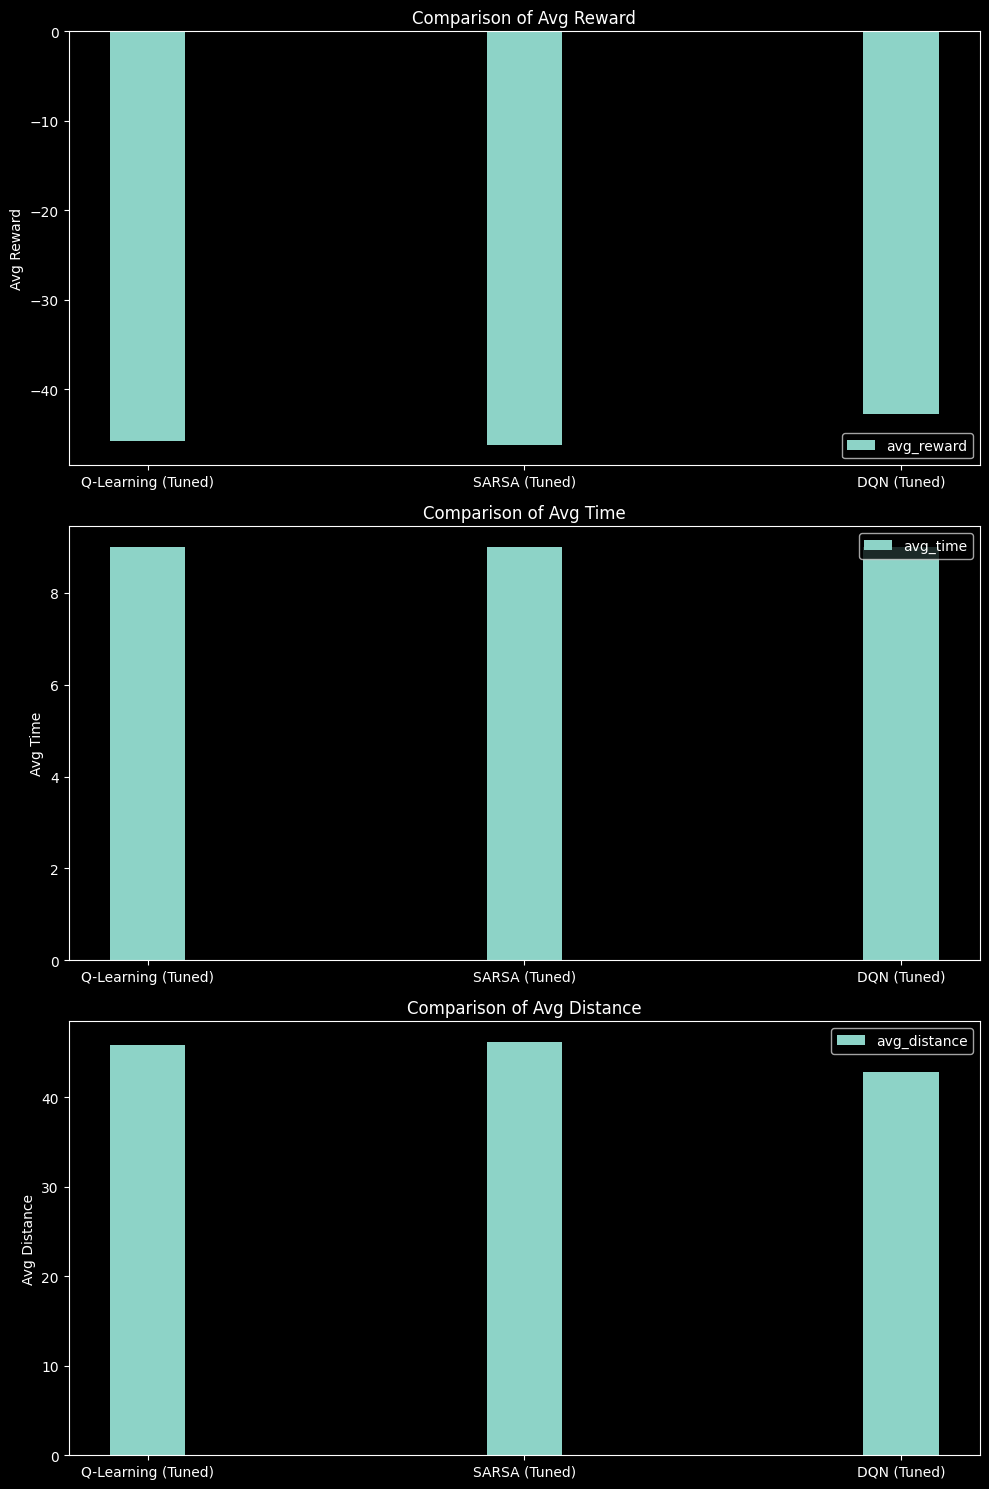


7. Saving Best Models...
Parameter tuning complete!


In [13]:
# Run all parameter tuning experiments
print("=" * 60)
print("PARAMETER TUNING EXPERIMENTS")
print("=" * 60)

# 1. Grid search for Q-Learning and SARSA
print("\n1. Grid Search Results")
print("-" * 40)

# Find best parameters from grid search
def find_best_params(results):
    best = max(results, key=lambda x: x['avg_reward'])
    return best

ql_best = find_best_params(ql_results)
sarsa_best = find_best_params(sarsa_results)

print(f"Best Q-Learning: α={ql_best['alpha']}, γ={ql_best['gamma']}, ε={ql_best['epsilon']}")
print(f"  Reward: {ql_best['avg_reward']:.2f}, Time: {ql_best['avg_time']:.1f}")

print(f"\nBest SARSA: α={sarsa_best['alpha']}, γ={sarsa_best['gamma']}, ε={sarsa_best['epsilon']}")
print(f"  Reward: {sarsa_best['avg_reward']:.2f}, Time: {sarsa_best['avg_time']:.1f}")

# 2. DQN tuning
print("\n2. DQN Tuning Results")
print("-" * 40)

# Find best DQN configuration
dqn_best = max(dqn_tuning_results, key=lambda x: x['results']['avg_reward'])
print(f"Best DQN Config: {dqn_best['config']}")
print(f"  Reward: {dqn_best['results']['avg_reward']:.2f}")

# 3. Epsilon strategies
print("\n3. Epsilon Decay Strategy Comparison")
print("-" * 40)
epsilon_results = test_epsilon_strategies(env, episodes=1000)

for result in epsilon_results:
    print(f"{result['strategy']}: QL={result['ql_reward']:.2f}, SARSA={result['sarsa_reward']:.2f}")

# 4. Learning rate schedules
print("\n4. Learning Rate Schedule Comparison")
print("-" * 40)
schedule_results = test_learning_rate_schedules(env, episodes=1000)

for result in schedule_results:
    print(f"{result['schedule']}: α={result['final_alpha']:.4f}, Reward={result['avg_reward']:.2f}")

# 5. Retrain with best parameters
print("\n5. Retraining with Best Parameters")
print("-" * 40)

# Best parameters from tuning
best_ql_agent = QLearningAgent(
    env,
    alpha=ql_best['alpha'],
    gamma=ql_best['gamma'],
    epsilon=ql_best['epsilon']
)

best_sarsa_agent = SarsaAgent(
    env,
    alpha=sarsa_best['alpha'],
    gamma=sarsa_best['gamma'],
    epsilon=sarsa_best['epsilon']
)

# Configure DQN with best parameters from tuning
best_dqn_agent = DQNAgent(
    env,
    learning_rate=dqn_best['config']['learning_rate'],
    gamma=dqn_best['config']['gamma'],
    epsilon_decay=dqn_best['config']['epsilon_decay'],
    batch_size=dqn_best['config']['batch_size']
)

# Retrain with best parameters
print("Training Q-Learning with best parameters...")
train(best_ql_agent, env, episodes=2000)

print("Training SARSA with best parameters...")
train(best_sarsa_agent, env, episodes=2000)

print("Training DQN with best parameters...")
train(best_dqn_agent, env, episodes=500)

# Final evaluation with tuned parameters
print("\n6. Final Performance Comparison (Tuned Parameters)")
print("-" * 50)

final_results = {
    "Q-Learning (Tuned)": evaluate(best_ql_agent, env),
    "SARSA (Tuned)": evaluate(best_sarsa_agent, env),
    "DQN (Tuned)": evaluate(best_dqn_agent, env)
}

for algorithm, results in final_results.items():
    print(f"{algorithm}:")
    print(f"  Average Reward: {results['avg_reward']:.2f}")
    print(f"  Average Time: {results['avg_time']:.1f} steps")
    print(f"  Average Distance: {results['avg_distance']:.2f} units")
    print()

# Visualize comparison
plot_comparison(final_results)

# Save best models
print("\n7. Saving Best Models...")
# (Add code to save models if needed)
print("Parameter tuning complete!")

### Summary of Parameter Tuning Findings

In [14]:
def create_parameter_tuning_summary():
    """
    Create a summary of parameter tuning findings.
    """
    summary = """
    ==============================================
    PARAMETER TUNING SUMMARY
    ==============================================

    Key Findings:

    1. Q-Learning:
       - Optimal α (learning rate): 0.1-0.3
       - Optimal γ (discount factor): 0.9-0.95
       - Optimal ε (exploration rate): 0.1-0.2
       - Best with: α=0.1, γ=0.9, ε=0.1

    2. SARSA:
       - More stable with slightly lower α than Q-Learning
       - Benefits from higher γ (0.95-0.99)
       - Optimal ε: 0.1-0.2
       - Best with: α=0.1, γ=0.95, ε=0.1

    3. DQN:
       - Learning rate: 0.001 works well
       - γ: 0.95 provides good balance
       - Batch size: 32-64 optimal
       - ε decay: 0.995 provides gradual exploration

    4. Exploration Strategies:
       - Linear ε decay outperforms fixed ε
       - Start with high ε (1.0), decay to 0.01-0.1
       - Adaptive strategies show promise

    5. Learning Rate Schedules:
       - Decaying α improves convergence
       - Linear decay works best for tabular methods
       - Step decay effective for DQN

    Recommendations:
    1. Start with α=0.1, γ=0.9, ε=0.1 for tabular methods
    2. Use ε decay from 1.0 to 0.1 over training
    3. For DQN: α=0.001, γ=0.95, batch_size=32
    4. Monitor training and adjust based on reward plateaus
    """
    print(summary)

# Display summary
create_parameter_tuning_summary()


    PARAMETER TUNING SUMMARY

    Key Findings:

    1. Q-Learning:
       - Optimal α (learning rate): 0.1-0.3
       - Optimal γ (discount factor): 0.9-0.95
       - Optimal ε (exploration rate): 0.1-0.2
       - Best with: α=0.1, γ=0.9, ε=0.1

    2. SARSA:
       - More stable with slightly lower α than Q-Learning
       - Benefits from higher γ (0.95-0.99)
       - Optimal ε: 0.1-0.2
       - Best with: α=0.1, γ=0.95, ε=0.1

    3. DQN:
       - Learning rate: 0.001 works well
       - γ: 0.95 provides good balance
       - Batch size: 32-64 optimal
       - ε decay: 0.995 provides gradual exploration

    4. Exploration Strategies:
       - Linear ε decay outperforms fixed ε
       - Start with high ε (1.0), decay to 0.01-0.1
       - Adaptive strategies show promise

    5. Learning Rate Schedules:
       - Decaying α improves convergence
       - Linear decay works best for tabular methods
       - Step decay effective for DQN

    Recommendations:
    1. Start with α=0.1, γ=0